# House price prediction

В этом блокноте для прогнозирования цены продажи дома используется градиентный бустинг деревьев решений.

---

## Задача:
Предсказать цену продажи для каждого дома.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

---
## Просмотр данных

In [3]:
train = pd.read_csv('./data/train.csv', index_col='Id')
test = pd.read_csv('./data/test.csv', index_col='Id')
train.columns.values # Список столбцов

array(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDriv

In [4]:
train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

## Первичная обработка данных
### Работа с пропущенными значениями

<AxesSubplot: >

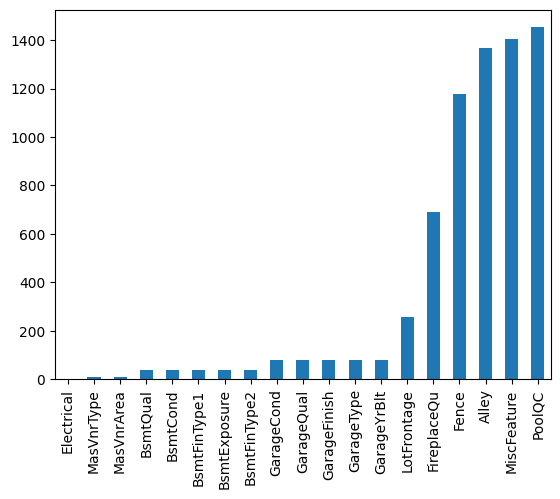

In [5]:
missing = train.isnull().sum() # 
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

В данных(как для тестовых, так и для тренировочных) есть 19 атрибутов имеющих пропущенные значения, из них 5 имеющих более 50% всех данных. В некоторых случаях `NA` означает отсутствие предмета, описываемого атрибутом, например, отсутствие бассейна, забора, отсутствия гаража и подвала. А в других - параметры этих предметов.

Заменим пропущенные значения на `None`(если тип данных категориальный) и на `0`(если он числовой).
Заменим значения `Na` столбца `Functional` на `Typ` — typical.

In [6]:
def na_to_none(data): # Меняет Na на None, 0 и Typ
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu' ):
        data[col] = data[col].fillna('None')
    for col in  ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        data[col] = data[col].fillna(0)
    data["Functional"] = data["Functional"].fillna("Typ")
    return data

train = na_to_none(train)
test = na_to_none(test)

Для следующих входных переменных мы заполняем пропущенные значения наиболее частым значением. Обратитим внимание, что переменная `LotFrontage`(Линейные футы улицы, связанной с собственностью) имеет тип ``float``. В общем, `LotFrontage` дома более или менее равен соседним домам. Следовательно, мы можем сгруппировать данные по району и заполнить недостающие значения медианным значением соседних домов.

In [7]:
def na_to_moda(data):
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
        data[col] = data[col].fillna(data[col].mode()[0])
    return data

train = na_to_moda(train)
test = na_to_moda(test)

Если мы посмотрим на столбец `Utilities`, почти все столбцы имеют одинаковое значение `AllPub`, что означает, что эта переменная не поможет в прогнозировании.

In [8]:
train = train.drop(['Utilities'], axis=1)
test = test.drop(['Utilities'], axis=1)

Проверим остались ли пропуски

In [9]:
test.isnull().sum().value_counts()

0    78
dtype: int64

Так как площадь играет важную роль в прогнозировании цены, давайте создадим новый столбец, содержащий общую площадь дома, включая подвал, первый и второй этажи

In [10]:
totsf = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train.insert(len(train.columns)-1, 'TotalSF', totsf)
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# Анализ Данных
Посмотрим на корреляцию `LivingArea` и `SalePrice`

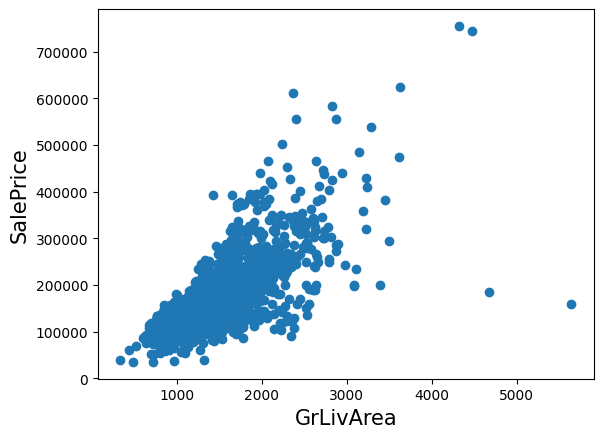

In [11]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

Обратим внимание на две точки справа внизу, где `GrLivingArea` больше, а `SalePrice` меньше. Эти две точки не подчиняются общей закономерности, которая хорошо видна. Передача этих двух точек данных в нашу модель может снизить производительность модели. И, следовательно, мы должны удалить эти выбросы перед моделированием.

In [12]:
train.GrLivArea.sort_values().tail(2)

Id
524     4676
1299    5642
Name: GrLivArea, dtype: int64

In [13]:
train = train[train.GrLivArea < 4676]

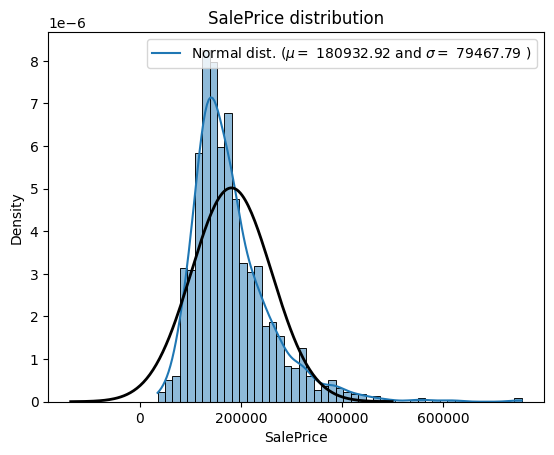

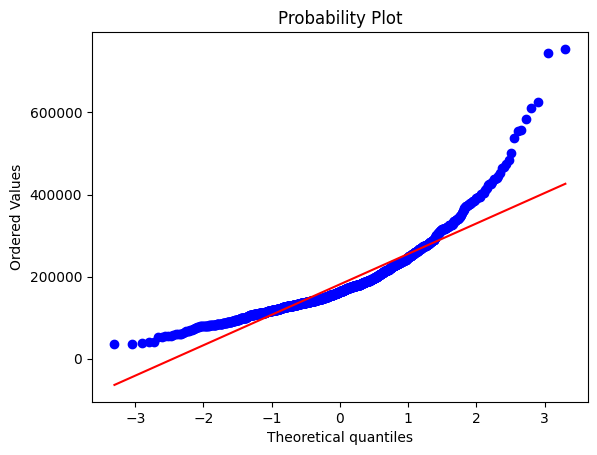

In [14]:
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = st.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)
ax = sns.histplot(x=train.SalePrice, stat='density', kde=True)
normal(train.SalePrice.mean(), train.SalePrice.std())

(mu, sigma) = st.norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.ylabel('Density')
plt.title('SalePrice distribution')

fig = plt.figure()
res = st.probplot(train['SalePrice'], plot=plt)
plt.show()

На графике видно, что данные распределены ненормально. Линейные модели предполагают, что данные будут распределены нормально. Следовательно, нам нужно преобразовать `SalePrice` так, чтобы она выглядела как нормальное распределение.

In [15]:
train["SalePrice"] = np.log1p(train["SalePrice"])

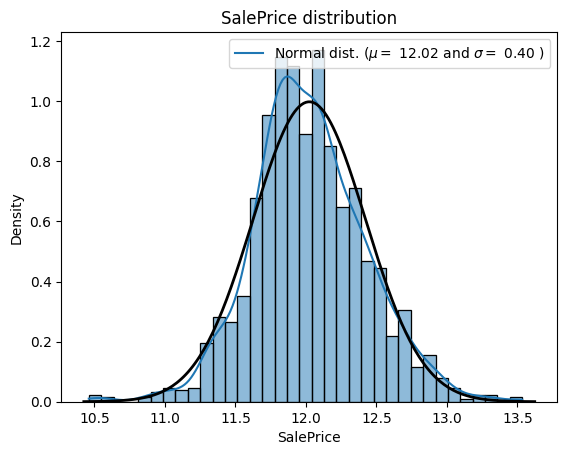

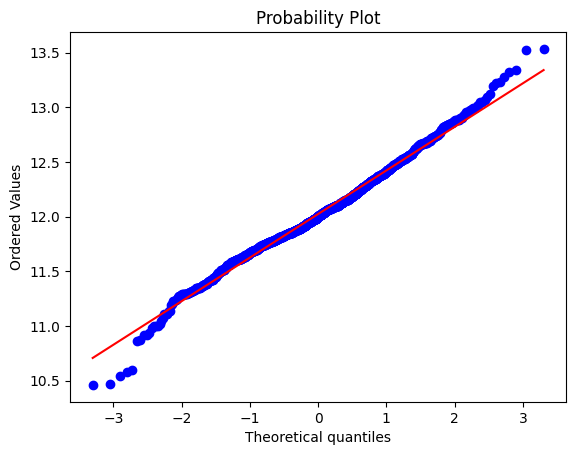

In [16]:
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = st.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)
ax = sns.histplot(x=train.SalePrice, stat='density', kde=True)
normal(train.SalePrice.mean(), train.SalePrice.std())

(mu, sigma) = st.norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.ylabel('Density')
plt.title('SalePrice distribution')

fig = plt.figure()
res = st.probplot(train['SalePrice'], plot=plt)
plt.show()

## Корреляция с SalePrice другими перемеными
Рассмотрим переменные, которые сильно коррелируют (как положительные, так и отрицательные) с нашей целевой переменной `SalePrice`.

In [17]:
corrmat = train.corr(numeric_only = True)
def get_correlated_features(corrdata, threshold):
    feature = []
    value = []
    for i , index in enumerate(corrdata.index):
        if abs(corrdata[index]) > threshold:
            feature.append(index)
            value.append(corrdata[index])
    df2 = pd.DataFrame(data = value, index=feature, columns=['CorrValue'] )
    return df2
corr_df = get_correlated_features(corrmat['SalePrice'], 0.5)[:-1]
corr_df

,CorrValue
OverallQual,0.821405
YearBuilt,0.587043
YearRemodAdd,0.565992
TotalBsmtSF,0.647563
1stFlrSF,0.620500
GrLivArea,0.725211
FullBath,0.595899
TotRmsAbvGrd,0.537702
GarageCars,0.681033
GarageArea,0.656129


Мы получили все переменные, которые сильно коррелируют с `SalePrice`. Теперь давайте посмотрим на значения коррелированных данных.

In [18]:
correlated_data = train[corr_df.index]
correlated_data.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,TotalSF
Id,,,,,,,,,,,
1,7,2003,2003,856,856,1710,2,8,2,548,2566
2,6,1976,1976,1262,1262,1262,2,6,2,460,2524
3,7,2001,2002,920,920,1786,2,6,2,608,2706
4,7,1915,1970,756,961,1717,1,7,3,642,2473
5,8,2000,2000,1145,1145,2198,2,9,3,836,3343


Давайте посмотрим на хитмап коррелированных данных.

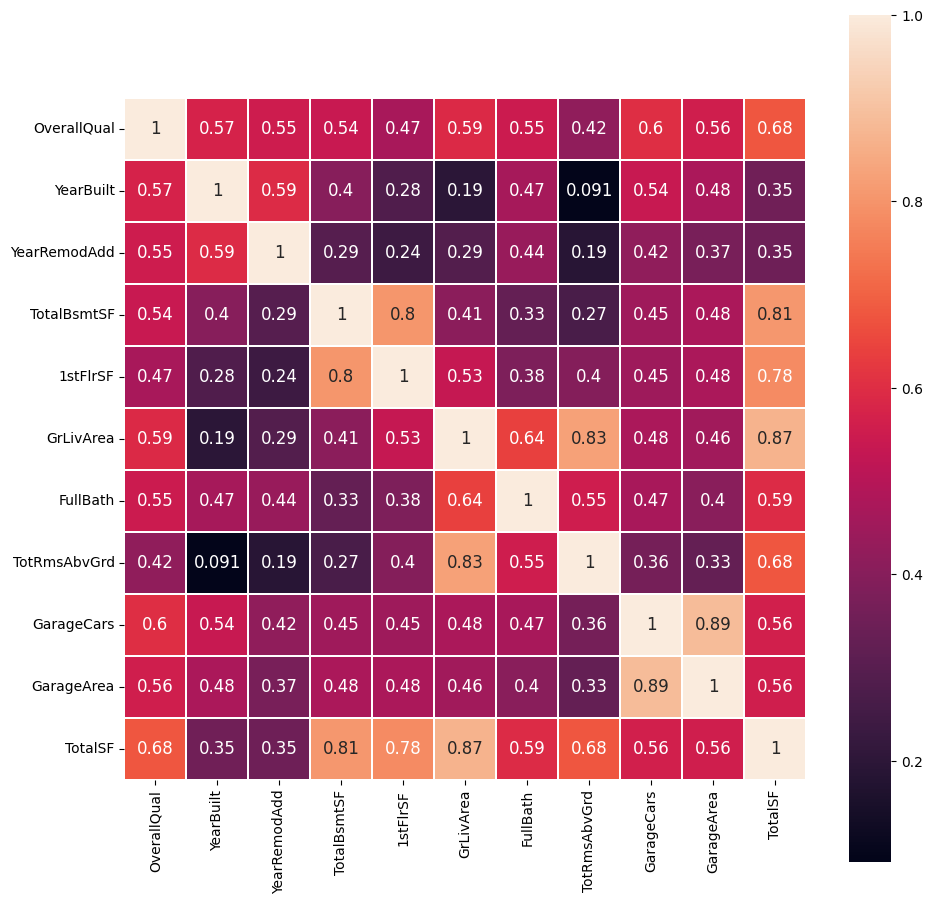

In [19]:
fig, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(correlated_data.corr(), annot = True, annot_kws={'size': 12}, square=True, linecolor='w', linewidths=0.1);

Из приведенного выше хитмапа `GarageArea`, `GrLivArea` и `OverallQual` тесно связаны с переменной `SalePrice`.

# Модель
## Градиентный бустинг 

In [20]:
X_train = train[corr_df.index]
y_train = train.SalePrice
X_test = test[corr_df.index]

In [21]:
from sklearn.model_selection import train_test_split

X_tr_dev, X_dev, y_tr_dev, y_dev = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [23]:
n = 50
nu = 0.1
trees = []
X_tr_dev['y_tr_dev_pred'] = y_tr_dev.mean()
for i in range(n):
    X_tr_dev['residual'] = y_tr_dev - X_tr_dev['y_tr_dev_pred']
    tree = DecisionTreeRegressor(max_depth=1)
    tree.fit(X_tr_dev[corr_df.index], X_tr_dev['residual'])
    X_tr_dev['y_tr_dev_pred'] += nu * tree.predict(X_tr_dev[corr_df.index])
    trees.append(tree)
    print(round(mean_absolute_error(y_tr_dev, X_tr_dev['y_tr_dev_pred']), 4), end=', ') 

0.2902, 0.2748, 0.2622, 0.2518, 0.24, 0.2326, 0.2232, 0.2138, 0.2079, 0.2001, 0.1943, 0.1877, 0.1821, 0.1787, 0.1747, 0.1699, 0.1659, 0.1633, 0.1599, 0.1574, 0.1554, 0.1524, 0.1496, 0.148, 0.1459, 0.1436, 0.1419, 0.1399, 0.1384, 0.1367, 0.1349, 0.1334, 0.1322, 0.1306, 0.1293, 0.1278, 0.1267, 0.126, 0.1248, 0.1238, 0.1227, 0.122, 0.1213, 0.1205, 0.1196, 0.1188, 0.118, 0.1173, 0.1168, 0.116, 

In [24]:
y_test_pred = y_tr_dev.mean()

In [25]:
for tree in trees:
    y_test_pred += nu * tree.predict(X_test[corr_df.index])

In [26]:
y_grad_pred = pd.DataFrame({'SalePrice': np.expm1(y_test_pred)}, index=test.index) #0.16640
y_grad_pred.to_csv('grad_b_submission.csv')